# Hudson Valley Gentrification and Changes in Farming

## Notebook 4: Variable Aggregation

In [168]:
import pandas as pd
import geopandas as gpd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import math
import json

In [169]:
api_key_stadia = os.getenv("STADIA_API_KEY")
api_key_census = os.getenv("CENSUS_API_KEY")
api_key_nass = os.getenv("QUICK_STATS_API_KEY")

In [170]:
proj_nys_east = 26918
proj_hudson_ft = 32118
proj_nyc_ft = 2263
proj_ea = 6933
proj_latlon = 4326

## Load data

In [171]:
# import agriculture census variable lookup tables
with open(r"data\zipcode_vars.json", "r") as zipcodevarfile:
    zipcode_vars = json.load(zipcodevarfile)
with open(r"data\county_vars.json", "r") as countyvarfile:
    county_vars = json.load(countyvarfile)

# import agriculture census data
ag_county2017_df = pd.read_csv(r"data\agcensus_county_2017.csv")
ag_county2022_df = pd.read_csv(r"data\agcensus_county_2022.csv")
ag_zipcode2017_df = pd.read_csv(r"data\agcensus_zipcode_2017.csv")
ag_zipcode2022_df = pd.read_csv(r"data\agcensus_zipcode_2022.csv")

# import ACS variable lookup tables
with open("data/acs_vars.json", "r") as acsvarfile:
    acs_vars = json.load(acsvarfile)

# import ACS data
acs_bg2017_df = pd.read_csv(r"data\core_bgs_acs5_2017_interp.csv", dtype={"STATE": str,
                                                                          "COUNTY": str,
                                                                          "TRACT": str,
                                                                          "BLOCK_GROUP": str,
                                                                          "GEOID": str})
acs_bg2017xwalk_df = pd.read_csv(r"data\core_bgs_acs5_2017_xwalk_to_2020.csv", dtype={"STATE": str,
                                                                                      "COUNTY": str,
                                                                                      "TRACT": str,
                                                                                      "BLOCK_GROUP": str,
                                                                                      "GEOID": str,
                                                                                      "GEOIDbg": str,
                                                                                      "bg_2020": str})
acs_bg2022_df = pd.read_csv(r"data\core_bgs_acs5_2022_interp.csv", dtype={"STATE": str,
                                                                          "COUNTY": str,
                                                                          "TRACT": str,
                                                                          "BLOCK_GROUP": str,
                                                                          "GEOID": str})
acs_tract2017_df = pd.read_csv(r"data\core_tracts_acs5_2017_interp.csv")
acs_tract2022_df = pd.read_csv(r"data\core_tracts_acs5_2022_interp.csv")

In [172]:
# import shapefiles
gdf_farms_clean = gpd.read_file(r"data\farms_clean.geojson").to_crs(proj_nys_east)
gdf_farms_core = gpd.read_file(r"data\farms_core.geojson").to_crs(proj_hudson_ft)

gdf_nys_counties = gpd.read_file("data/NYS_Civil_Boundaries_2455759864913236436.geojson").to_crs(proj_nys_east)
gdf_zctas_core = gpd.read_file(r"data\zctas_core.geojson").to_crs(proj_hudson_ft)
gdf_tracts2017_core = gpd.read_file("data/tracts_core_2017.geojson").to_crs(proj_hudson_ft)
gdf_tracts2022_core = gpd.read_file("data/tracts_core_2022.geojson").to_crs(proj_hudson_ft)
gdf_bgs2022_core = gpd.read_file("data/bgs_core_2022.geojson").to_crs(proj_hudson_ft)
gdf_counties_core = gpd.read_file("data/counties_core.geojson").to_crs(proj_hudson_ft)

In [173]:
acs_var_grp_agg = ["B25039",'B25057','B25058','B25059','B25071','B19013']
acs_var_grp_raw = ['B01003',"B25003","B25038",'B25056','B25074','B25004','B19001']
acs_var_groups = acs_var_grp_agg + acs_var_grp_raw

In [174]:
acs_bg2017_df = acs_bg2017_df.assign(GEOIDbg = acs_bg2017_df.GEOID+acs_bg2017_df.BLOCK_GROUP)

In [175]:
acs_bg2022_df = acs_bg2022_df.assign(GEOIDbg = acs_bg2022_df.GEOID+acs_bg2022_df.BLOCK_GROUP)

## Aggregate block-group-level ACS data

In [176]:
def trimean(q1, q2, q3):
    trimean = (q1 + 2*q2 + q3)/4
    return trimean

rng = np.random.default_rng(123456789012345)

In [177]:
acs2017_df = acs_bg2017xwalk_df.copy()
acs2022_df = acs_bg2022_df.copy()
for df in [acs2017_df, acs2022_df]:
    df['total_pop'] = df['B01003_001E']
    df.drop('B01003_001E', axis=1, inplace=True)
    df['total_occupied'] = df['B25003_001E']
    df['total_occupied_renter'] = df['B25003_003E']
    df['total_occupied_owner'] = df['B25003_002E']
    df.drop(['B25003_001E','B25003_003E','B25003_002E'], axis=1, inplace=True)
    df['total_vacant'] = df['B25004_001E']
    df['seasonal_vacancy'] = df['B25004_006E']
    df.drop([col for col in df.columns if col.startswith('B25004')], axis=1, inplace=True)
    df['total_dwellings'] = df['total_vacant'] + df['total_occupied']
acs2017_df.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLOCK_GROUP', 'NAME', 'GEOID', 'GEOIDbg',
       'bg_2020', 'B25038_011E', 'B25038_010E',
       ...
       'B19001_011E', 'B19001_012E', 'B19001_013E', 'total_pop',
       'total_occupied', 'total_occupied_renter', 'total_occupied_owner',
       'total_vacant', 'seasonal_vacancy', 'total_dwellings'],
      dtype='object', length=138)

### Create lookup dataframes for binned values

In [178]:
{key: var for key, var in acs_vars['2017'].items() if key in acs_var_grp_raw}

{'B01003': {'universe': 'Total population',
  'description': 'TOTAL POPULATION',
  'variables': [{'variable': 'B01003_001E',
    'label': 'Estimate!!Total',
    'type': 'int'}]},
 'B25003': {'universe': 'Occupied housing units',
  'description': 'TENURE',
  'variables': [{'variable': 'B25003_003E',
    'label': 'Estimate!!Total!!Renter occupied',
    'type': 'int'},
   {'variable': 'B25003_002E',
    'label': 'Estimate!!Total!!Owner occupied',
    'type': 'int'},
   {'variable': 'B25003_001E', 'label': 'Estimate!!Total', 'type': 'int'}]},
 'B25038': {'universe': 'Occupied housing units',
  'description': 'TENURE BY YEAR HOUSEHOLDER MOVED INTO UNIT',
  'variables': [{'variable': 'B25038_011E',
    'label': 'Estimate!!Total!!Renter occupied!!Moved in 2010 to 2014',
    'type': 'int'},
   {'variable': 'B25038_010E',
    'label': 'Estimate!!Total!!Renter occupied!!Moved in 2015 or later',
    'type': 'int'},
   {'variable': 'B25038_015E',
    'label': 'Estimate!!Total!!Renter occupied!!Mov

In [179]:
{key: var['description'] for key, var in acs_vars['2017'].items() if key in acs_var_grp_raw}

{'B01003': 'TOTAL POPULATION',
 'B25003': 'TENURE',
 'B25038': 'TENURE BY YEAR HOUSEHOLDER MOVED INTO UNIT',
 'B25056': 'CONTRACT RENT',
 'B25074': 'HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS',
 'B25004': 'VACANCY STATUS',
 'B19001': 'HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2017 INFLATION-ADJUSTED DOLLARS)'}

In [181]:
for year in ['2017','2022']:
    for vargroup in acs_vars[year]:
        if vargroup in acs_var_grp_raw:
            acs_vars[year][vargroup]['df'] = pd.DataFrame.from_dict(acs_vars[year][vargroup]['variables'])
acs_vars

{'2017': {'B25039': {'universe': 'Occupied housing units',
   'description': 'MEDIAN YEAR HOUSEHOLDER MOVED INTO UNIT BY TENURE',
   'variables': [{'variable': 'B25039_002E',
     'label': 'Estimate!!Median year householder moved into unit --!!Owner occupied',
     'type': 'int'},
    {'variable': 'B25039_001E',
     'label': 'Estimate!!Median year householder moved into unit --!!Total',
     'type': 'int'},
    {'variable': 'B25039_003E',
     'label': 'Estimate!!Median year householder moved into unit --!!Renter occupied',
     'type': 'int'}]},
  'B25057': {'universe': 'Renter-occupied housing units paying cash rent',
   'description': 'LOWER CONTRACT RENT QUARTILE (DOLLARS)',
   'variables': [{'variable': 'B25057_001E',
     'label': 'Estimate!!Lower contract rent quartile',
     'type': 'int'}]},
  'B25058': {'universe': 'Renter-occupied housing units paying cash rent',
   'description': 'MEDIAN CONTRACT RENT (DOLLARS)',
   'variables': [{'variable': 'B25058_001E',
     'label': '

In [182]:
for year in ['2017','2022']:
    for vargroup in acs_vars[year]:
        if 'df' in acs_vars[year][vargroup]:
            print(acs_vars[year][vargroup]['df'])

      variable            label type
0  B01003_001E  Estimate!!Total  int
      variable                             label type
0  B25003_003E  Estimate!!Total!!Renter occupied  int
1  B25003_002E   Estimate!!Total!!Owner occupied  int
2  B25003_001E                   Estimate!!Total  int
       variable                                              label type
0   B25038_011E  Estimate!!Total!!Renter occupied!!Moved in 201...  int
1   B25038_010E  Estimate!!Total!!Renter occupied!!Moved in 201...  int
2   B25038_015E  Estimate!!Total!!Renter occupied!!Moved in 197...  int
3   B25038_014E  Estimate!!Total!!Renter occupied!!Moved in 198...  int
4   B25038_013E  Estimate!!Total!!Renter occupied!!Moved in 199...  int
5   B25038_012E  Estimate!!Total!!Renter occupied!!Moved in 200...  int
6   B25038_003E  Estimate!!Total!!Owner occupied!!Moved in 2015...  int
7   B25038_002E                    Estimate!!Total!!Owner occupied  int
8   B25038_001E                                    Estimate!!T

In [183]:
acs_var_grp_raw

['B01003', 'B25003', 'B25038', 'B25056', 'B25074', 'B25004', 'B19001']

In [ ]:
acsvar_df_names = []
df_b01003 = acs_vars['2017']['B01003']['df'].copy().sort_values('variable')
acsvar_df_names.append('df_b01003')
df_b25003 = acs_vars['2017']['B25003']['df'].copy().sort_values('variable')
acsvar_df_names.append('df_b25003')
df_b25038_2017 = acs_vars['2017']['B25038']['df'].copy().sort_values('variable') # needs aggregating
acsvar_df_names.append('df_b25038_2017')
df_b25056 = acs_vars['2017']['B25056']['df'].copy().sort_values('variable') # needs aggregating
acsvar_df_names.append('df_b25056')
df_b25074 = acs_vars['2017']['B25074']['df'].copy().sort_values('variable') # needs aggregating
acsvar_df_names.append('df_b25074')
df_b25004 = acs_vars['2017']['B25004']['df'].copy().sort_values('variable')
acsvar_df_names.append('df_b25004')
df_b19001 = acs_vars['2017']['B19001']['df'].copy().sort_values('variable') # needs aggregating
acsvar_df_names.append('df_b19001')
df_b25038_2022 = acs_vars['2022']['B25038']['df'].copy().sort_values('variable') # needs aggregating
acsvar_df_names.append('df_b25038_2022')

In [205]:
acsvar_df_names

['df_b01003',
 'df_b25003',
 'df_b25038_2017',
 'df_b25056',
 'df_b25074',
 'df_b25004',
 'df_b19001',
 'df_b25038_2022']

In [162]:
bgs = list(acs_bg2017xwalk_df.bg_2020.unique())
bgs_dict = {}

#### Year moved in

In [206]:
eval(acsvar_df_names[2]).label.unique()

array(['Estimate!!Total', 'Estimate!!Total!!Owner occupied',
       'Estimate!!Total!!Owner occupied!!Moved in 2015 or later',
       'Estimate!!Total!!Owner occupied!!Moved in 2010 to 2014',
       'Estimate!!Total!!Owner occupied!!Moved in 2000 to 2009',
       'Estimate!!Total!!Owner occupied!!Moved in 1990 to 1999',
       'Estimate!!Total!!Owner occupied!!Moved in 1980 to 1989',
       'Estimate!!Total!!Owner occupied!!Moved in 1979 or earlier',
       'Estimate!!Total!!Renter occupied',
       'Estimate!!Total!!Renter occupied!!Moved in 2015 or later',
       'Estimate!!Total!!Renter occupied!!Moved in 2010 to 2014',
       'Estimate!!Total!!Renter occupied!!Moved in 2000 to 2009',
       'Estimate!!Total!!Renter occupied!!Moved in 1990 to 1999',
       'Estimate!!Total!!Renter occupied!!Moved in 1980 to 1989',
       'Estimate!!Total!!Renter occupied!!Moved in 1979 or earlier'],
      dtype=object)

In [214]:
df_b25038 = {}
for i, df in enumerate([df_b25038_2017, df_b25038_2022]):
    if i == 0:
        year = '2017'
    else:
        year = '2022'
    df = df.query('variable not in ["B25038_001E","B25038_002E","B25038_009E"]').copy()
    df['label'] = df['label'].str.replace(':','')
    df['label'] = df['label'].str.replace('Moved in ','')
    df['min'] = 0
    df['max'] = 0
    for idx, row in df.iterrows():
        label = row.label.split('!!')
        if len(label[-1].split(' to ')) == 2:
            df.loc[idx, 'min'] = int(label[-1].split(' to ')[0])
            df.loc[idx, 'max'] = int(label[-1].split(' to ')[1])
        elif len(label[-1].split(' or ')) == 2:
            if label[-1].split(' or ')[1] == 'later':
                df.loc[idx, 'min'] = int(label[-1].split(' or ')[0])
                df.loc[idx, 'max'] = int(year)
            else:
                df.loc[idx, 'max'] = int(label[-1].split(' or ')[0])
                df.loc[idx, 'min'] = int(label[-1].split(' or ')[0]) - 45
    #df_b19001 = df_b19001.assign(avg = lambda df: (df['min']+df['max'])/2)
    df_b25038[year] = df

df_b25038['2017']

,variable,label,type,min,max
6,B25038_003E,Estimate!!Total!!Owner occupied!!2015 or later,int,2015,2017
13,B25038_004E,Estimate!!Total!!Owner occupied!!2010 to 2014,int,2010,2014
12,B25038_005E,Estimate!!Total!!Owner occupied!!2000 to 2009,int,2000,2009
11,B25038_006E,Estimate!!Total!!Owner occupied!!1990 to 1999,int,1990,1999
10,B25038_007E,Estimate!!Total!!Owner occupied!!1980 to 1989,int,1980,1989
9,B25038_008E,Estimate!!Total!!Owner occupied!!1979 or earlier,int,1934,1979
1,B25038_010E,Estimate!!Total!!Renter occupied!!2015 or later,int,2015,2017
0,B25038_011E,Estimate!!Total!!Renter occupied!!2010 to 2014,int,2010,2014
5,B25038_012E,Estimate!!Total!!Renter occupied!!2000 to 2009,int,2000,2009
4,B25038_013E,Estimate!!Total!!Renter occupied!!1990 to 1999,int,1990,1999


In [217]:
df_b25038['2022'] = df_b25038['2022'].merge(df_b25038['2017'], how='left', on=['label','type','min','max'], suffixes=['','_2017'])
df_b25038['2022']

,variable,label,type,min,max,variable_2017
0,B25038_003E,Estimate!!Total!!Owner occupied!!2021 or later,int,2021,2022,NaN
1,B25038_004E,Estimate!!Total!!Owner occupied!!2018 to 2020,int,2018,2020,NaN
2,B25038_005E,Estimate!!Total!!Owner occupied!!2010 to 2017,int,2010,2017,NaN
3,B25038_006E,Estimate!!Total!!Owner occupied!!2000 to 2009,int,2000,2009,B25038_005E
4,B25038_007E,Estimate!!Total!!Owner occupied!!1990 to 1999,int,1990,1999,B25038_006E
5,B25038_008E,Estimate!!Total!!Owner occupied!!1989 or earlier,int,1944,1989,NaN
6,B25038_010E,Estimate!!Total!!Renter occupied!!2021 or later,int,2021,2022,NaN
7,B25038_011E,Estimate!!Total!!Renter occupied!!2018 to 2020,int,2018,2020,NaN
8,B25038_012E,Estimate!!Total!!Renter occupied!!2010 to 2017,int,2010,2017,NaN
9,B25038_013E,Estimate!!Total!!Renter occupied!!2000 to 2009,int,2000,2009,B25038_012E


In [ ]:
# df_b25038_renter_2017 = df_b25038_2017[df_b25038_2017.label.str.contains('Renter')].copy()
# df_b25038_owner_2017 = df_b25038_2017[df_b25038_2017.label.str.contains('Owner')].copy()
# df_b25038_renter_2022 = df_b25038_2022[df_b25038_2022.label.str.contains('Renter')].copy()
# df_b25038_owner_2022 = df_b25038_2022[df_b25038_2022.label.str.contains('Owner')].copy()

#### Contract rent

In [199]:
eval(acsvar_df_names[3])

,variable,label,type
26,B25056_001E,Estimate!!Total,int
24,B25056_002E,Estimate!!Total!!With cash rent,int
25,B25056_003E,Estimate!!Total!!With cash rent!!Less than $100,int
22,B25056_004E,Estimate!!Total!!With cash rent!!$100 to $149,int
23,B25056_005E,Estimate!!Total!!With cash rent!!$150 to $199,int
20,B25056_006E,Estimate!!Total!!With cash rent!!$200 to $249,int
21,B25056_007E,Estimate!!Total!!With cash rent!!$250 to $299,int
19,B25056_008E,Estimate!!Total!!With cash rent!!$300 to $349,int
18,B25056_009E,Estimate!!Total!!With cash rent!!$350 to $399,int
8,B25056_010E,Estimate!!Total!!With cash rent!!$400 to $449,int


#### Gross rent as percentage of income

In [200]:
eval(acsvar_df_names[4])

,variable,label,type
0,B25074_001E,Estimate!!Total,int
2,B25074_002E,"Estimate!!Total!!Less than $10,000",int
1,B25074_003E,"Estimate!!Total!!Less than $10,000!!Less than ...",int
4,B25074_004E,"Estimate!!Total!!Less than $10,000!!20.0 to 24...",int
3,B25074_005E,"Estimate!!Total!!Less than $10,000!!25.0 to 29...",int
...,...,...,...
60,B25074_060E,"Estimate!!Total!!$100,000 or more!!30.0 to 34....",int
59,B25074_061E,"Estimate!!Total!!$100,000 or more!!35.0 to 39....",int
62,B25074_062E,"Estimate!!Total!!$100,000 or more!!40.0 to 49....",int
61,B25074_063E,"Estimate!!Total!!$100,000 or more!!50.0 percen...",int


In [201]:
list(eval(acsvar_df_names[4]).label)

# HOUSEHOLD INCOME BY GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS
## split label on !!:
### 2-part label is total people paying rent
### 3-part labels are number of people in each income bracket
### 4-part labels are number of people in a given income bracket paying a certain decile percentage of their income as rent

['Estimate!!Total',
 'Estimate!!Total!!Less than $10,000',
 'Estimate!!Total!!Less than $10,000!!Less than 20.0 percent',
 'Estimate!!Total!!Less than $10,000!!20.0 to 24.9 percent',
 'Estimate!!Total!!Less than $10,000!!25.0 to 29.9 percent',
 'Estimate!!Total!!Less than $10,000!!30.0 to 34.9 percent',
 'Estimate!!Total!!Less than $10,000!!35.0 to 39.9 percent',
 'Estimate!!Total!!Less than $10,000!!40.0 to 49.9 percent',
 'Estimate!!Total!!Less than $10,000!!50.0 percent or more',
 'Estimate!!Total!!Less than $10,000!!Not computed',
 'Estimate!!Total!!$10,000 to $19,999',
 'Estimate!!Total!!$10,000 to $19,999!!Less than 20.0 percent',
 'Estimate!!Total!!$10,000 to $19,999!!20.0 to 24.9 percent',
 'Estimate!!Total!!$10,000 to $19,999!!25.0 to 29.9 percent',
 'Estimate!!Total!!$10,000 to $19,999!!30.0 to 34.9 percent',
 'Estimate!!Total!!$10,000 to $19,999!!35.0 to 39.9 percent',
 'Estimate!!Total!!$10,000 to $19,999!!40.0 to 49.9 percent',
 'Estimate!!Total!!$10,000 to $19,999!!50.0 p

#### Income

In [203]:
eval(acsvar_df_names[6])

,variable,label,type
8,B19001_001E,Estimate!!Total,int
4,B19001_002E,"Estimate!!Total!!Less than $10,000",int
5,B19001_003E,"Estimate!!Total!!$10,000 to $14,999",int
6,B19001_004E,"Estimate!!Total!!$15,000 to $19,999",int
7,B19001_005E,"Estimate!!Total!!$20,000 to $24,999",int
0,B19001_006E,"Estimate!!Total!!$25,000 to $29,999",int
1,B19001_007E,"Estimate!!Total!!$30,000 to $34,999",int
2,B19001_008E,"Estimate!!Total!!$35,000 to $39,999",int
3,B19001_009E,"Estimate!!Total!!$40,000 to $44,999",int
13,B19001_010E,"Estimate!!Total!!$45,000 to $49,999",int


In [157]:
df_b19001 = df_b19001.query('variable != "B19001_001E"').copy()
df_b19001['label'] = df_b19001['label'].str.replace(r'[$,]','',regex=True)
df_b19001['min'] = 0
df_b19001['max'] = 0
for idx, row in df_b19001.iterrows():
    label = row.label.split('!!')
    if len(label[-1].split(' to ')) == 2:
        df_b19001.loc[idx, 'min'] = int(label[-1].split(' to ')[0])
        df_b19001.loc[idx, 'max'] = int(label[-1].split(' to ')[1])
    else:
        if label[-1].startswith('L'):
            df_b19001.loc[idx, 'min'] = 0
            df_b19001.loc[idx, 'max'] = 9999
        else:
            df_b19001.loc[idx, 'min'] = 200000
#            df_b19001.loc[idx, 'max'] = None
            df_b19001.loc[idx, 'max'] = 400000
#df_b19001 = df_b19001.assign(avg = lambda df: (df['min']+df['max'])/2)
df_b19001.head()

,variable,label,type,min,max
0,B19001_006E,Estimate!!Total!!25000 to 29999,int,25000,29999
1,B19001_007E,Estimate!!Total!!30000 to 34999,int,30000,34999
2,B19001_008E,Estimate!!Total!!35000 to 39999,int,35000,39999
3,B19001_009E,Estimate!!Total!!40000 to 44999,int,40000,44999
4,B19001_002E,Estimate!!Total!!Less than 10000,int,0,9999


In [158]:
acs_bg2017xwalk_income = acs_bg2017xwalk_df[list(acs_bg2017xwalk_df.columns[:8]) + [col for col in acs_bg2017xwalk_df.columns if col.startswith('B19001')]].melt(id_vars=tuple(list(acs_bg2017xwalk_df.columns[:8]) + ['B19001_001E'])).copy().sort_values(by="variable")

In [220]:
acs_bg2022_df.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLOCK_GROUP', 'NAME', 'B25039_002E',
       'B25039_001E', 'B25039_003E', 'B25057_001E', 'B25058_001E',
       ...
       'B19001_014E', 'B19001_015E', 'B19001_016E', 'B19001_017E',
       'B19001_010E', 'B19001_011E', 'B19001_012E', 'B19001_013E', 'GEOID',
       'GEOIDbg'],
      dtype='object', length=150)

In [221]:
acs_bg2022_income = acs_bg2022_df[list(acs_bg2022_df.columns[:5]) + list(acs_bg2022_df.columns[-2:]) + [col for col in acs_bg2022_df.columns if col.startswith('B19001')]].melt(id_vars=tuple(list(acs_bg2022_df.columns[:5]) + list(acs_bg2022_df.columns[-2:]) + ['B19001_001E'])).copy().sort_values(by="variable")

In [159]:
acs_bg2017xwalk_income.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,GEOID,GEOIDbg,bg_2020,B19001_001E,variable,value
3748,36,001,014301,1,Block Group 1; Census Tract 143.01; Albany Cou...,36001014301,360010143011,360010143011,390.000000,B19001_002E,17.000000
4366,36,071,014601,3,Block Group 3; Census Tract 146.01; Orange Cou...,36071014601,360710146013,360710146013,387.663299,B19001_002E,6.401045
4367,36,071,014601,4,Block Group 4; Census Tract 146.01; Orange Cou...,36071014601,360710146014,360710146014,127.972752,B19001_002E,1.029973
4368,36,071,014602,1,Block Group 1; Census Tract 146.02; Orange Cou...,36071014602,360710146021,360710146021,482.000000,B19001_002E,14.000000
4369,36,071,014602,2,Block Group 2; Census Tract 146.02; Orange Cou...,36071014602,360710146022,360710146022,334.000000,B19001_002E,0.000000


In [222]:
acs_bg2022_income.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,GEOID,GEOIDbg,B19001_001E,variable,value
3748,36,001,014301,1,Block Group 1; Census Tract 143.01; Albany Cou...,36001014301,360010143011,351,B19001_002E,0
4366,36,071,014601,3,Block Group 3; Census Tract 146.01; Orange Cou...,36071014601,360710146013,437,B19001_002E,46
4367,36,071,014601,4,Block Group 4; Census Tract 146.01; Orange Cou...,36071014601,360710146014,273,B19001_002E,0
4368,36,071,014602,1,Block Group 1; Census Tract 146.02; Orange Cou...,36071014602,360710146021,396,B19001_002E,55
4369,36,071,014602,2,Block Group 2; Census Tract 146.02; Orange Cou...,36071014602,360710146022,402,B19001_002E,61


In [160]:
acs_bg2017xwalk_income = acs_bg2017xwalk_income.merge(df_b19001[['variable','min','max']], how='left', on='variable').copy()

In [161]:
acs_bg2017xwalk_income.head()

,STATE,COUNTY,TRACT,BLOCK_GROUP,NAME,GEOID,GEOIDbg,bg_2020,B19001_001E,variable,value,min,max
0,36,001,014301,1,Block Group 1; Census Tract 143.01; Albany Cou...,36001014301,360010143011,360010143011,390.000000,B19001_002E,17.000000,0,9999
1,36,071,014601,3,Block Group 3; Census Tract 146.01; Orange Cou...,36071014601,360710146013,360710146013,387.663299,B19001_002E,6.401045,0,9999
2,36,071,014601,4,Block Group 4; Census Tract 146.01; Orange Cou...,36071014601,360710146014,360710146014,127.972752,B19001_002E,1.029973,0,9999
3,36,071,014602,1,Block Group 1; Census Tract 146.02; Orange Cou...,36071014602,360710146021,360710146021,482.000000,B19001_002E,14.000000,0,9999
4,36,071,014602,2,Block Group 2; Census Tract 146.02; Orange Cou...,36071014602,360710146022,360710146022,334.000000,B19001_002E,0.000000,0,9999


In [ ]:
#rng = np.random.default_rng(123456789012345)

bgs_dict['income_2017'] = []
bgs_dict['income_2022'] = []

#for df in []
for bg in bgs:
    bgs_dict['income_2017'].append({'bg': bg})
    bg_df = acs_bg2017xwalk_income.query('bg_2020 == @bg')
    random_vals = []

    for idx, row in bg_df.query('value > 0').iterrows():
        vals = rng.integers(low=row['min'], high=row['max']+1, size=round(row['value']))
        random_vals += list(vals)

    if len(random_vals) == 0:
#        print(bg)
        continue

    q1 = np.quantile(random_vals, .25)
    q2 = np.quantile(random_vals, .50)
    q3 = np.quantile(random_vals, .75)
    trim = trimean(q1,q2,q3) 

    bgs_dict['income_2017'][-1]['q1'] = q1
    bgs_dict['income_2017'][-1]['q2'] = q2
    bgs_dict['income_2017'][-1]['q3'] = q3
    bgs_dict['income_2017'][-1]['trimean'] = trim


In [164]:
pd.DataFrame.from_dict(bgs_dict['income_2017'])

,bg,q1,q2,q3,trimean
0,360010143011,27805.75,87708.5,120029.00,80812.9375
1,360010143012,33315.50,79576.0,149095.50,85390.7500
2,360010143041,32305.00,57714.0,94658.00,60597.7500
3,360010143042,49783.75,90001.5,132505.00,90572.9375
4,360010144011,41499.00,61718.0,99785.25,66180.0625
...,...,...,...,...,...
932,361119550021,26841.00,50276.0,61850.50,47310.8750
933,361119550022,36766.75,60795.5,116380.00,68684.4375
934,361119554001,37707.00,69953.0,108729.00,71585.5000
935,361119554002,45903.75,104338.0,148802.75,100845.6250


<Axes: >

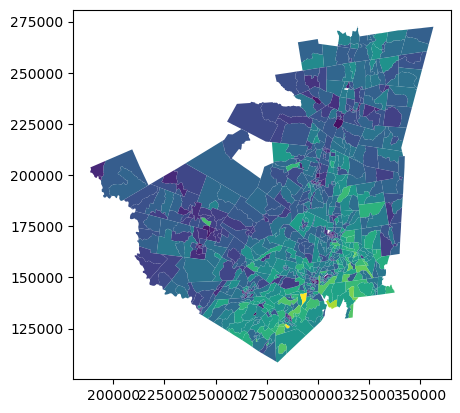

In [166]:
gdf_bgs2022_core.merge(pd.DataFrame.from_dict(bgs_dict['income_2017']), how='left', left_on="GEOID_x", right_on="bg").plot(column='q2')

In [141]:
gdf_bgs2022_core.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'GEOID_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       ...
       'B19001_001E', 'B19001_014E', 'B19001_015E', 'B19001_016E',
       'B19001_017E', 'B19001_010E', 'B19001_011E', 'B19001_012E',
       'B19001_013E', 'geometry'],
      dtype='object', length=156)

<Axes: >

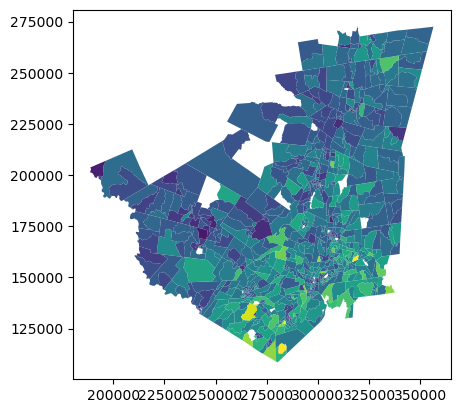

In [142]:
gdf_bgs2022_core.merge(acs_bg2022_df, how='left', left_on="GEOID_x", right_on="GEOIDbg").plot(column="B19013_001E")

<Axes: >

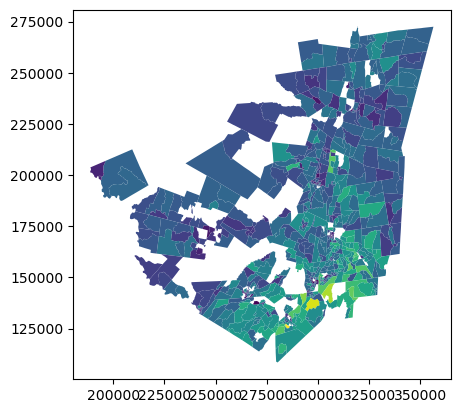

In [145]:
gdf_bgs2022_core.merge(acs_bg2017_df, how='left', left_on="GEOID_x", right_on="GEOIDbg").plot(column="B19013_001E")